# Potato Disease Classification

Dataset: https://www.kaggle.com/arjuntejaswi/plant-village



Importing Libraries

In [103]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Definig constants

In [104]:
B_S = 32
I_S = 256
Channel=3
epoches=10

# Import dataset using tensorflow

Used image_dataset_from_directory api to load all images in tensorflow dataset:

In [105]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/ravin/OneDrive/Desktop/Spring 22/ML/Project/data",
    seed=123,
    shuffle=True,
    image_size=(I_S,I_S),
    batch_size=B_S
)

Found 3630 files belonging to 4 classes.


# Define classes and labels

Each element in the dataset is a tuple. 
First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [106]:

class_names = df.class_names
class_names

['Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [107]:

for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 2 1 0 1 0 2 0 2 0 0 1 2 1 0 1 1 0 0 2 1 0 0 0 2 1 1 1 1]


# Visualize some of the images from our dataset


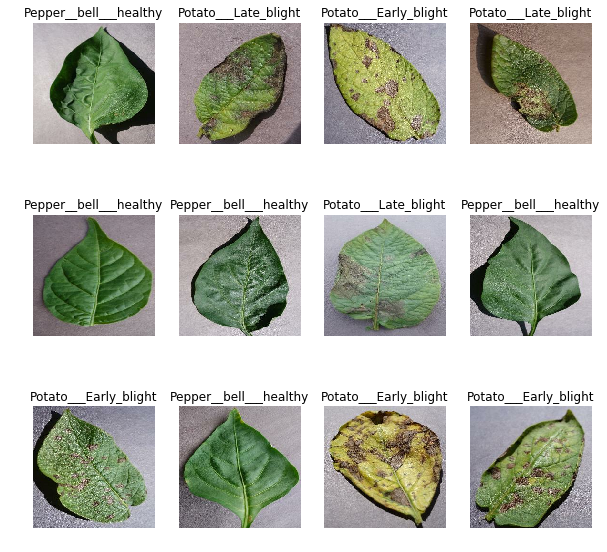

In [108]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset



Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training
2..Validation: Dataset to be tested against while training
3.Test: Dataset to be tested against after we trained a model

In [132]:
len(df)


114

In [133]:
train_size = 0.8
len(df)*train_size

91.2

In [134]:
train_df = df.take(54)
len(train_df)

54

In [135]:
test_df = df.skip(54)
len(test_df)

60

In [136]:
test_size=0.1
len(df)*test_size


11.4

In [137]:
val_ds = test_df.take(6)
len(val_ds)

6

In [138]:
test_df = test_df.skip(6)
len(test_df)

54

In [139]:
def dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    test_size = int(val_split * ds_size)
    
    train_df = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(test_size)
    test_df = ds.skip(train_size).skip(test_size)
    
    return train_df, val_ds, test_df

In [140]:
train_df, val_ds, test_df = dataset_partitions(df)


In [141]:
len(val_ds)


11

In [142]:
len(test_df)


12

# Cache, Shuffle, and Prefetch the Dataset


In [143]:

train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model biulding

#### Creating a Layer for Resizing and Normalization



Resizing it to the desired size, is very important before we feed our image to network. 
We should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). to improve performance of model.
We can add that as a layer in our sequential model.

In [144]:
resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(I_S, I_S),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

When we have less data, data augmentation is needed to boost the accuracy of our model.

In [145]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [146]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


# Model Architecture


We use a CNN coupled with a Softmax activation in the output layer. 

We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. 
CNN is popular for image classification tasks.

In [147]:
input_shape = (B_S, I_S, I_S, Channel)
n_classes = 4

cnn_model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

cnn_model.build(input_shape=input_shape)

In [148]:
cnn_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (32, 30, 30, 64)        

# Compiling the Model


adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric is added.

In [149]:
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [150]:
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [152]:
history = cnn_model.fit(
    train_df,
    batch_size=B_S,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
91/91 [==============================] - 212s 2s/step - loss: 0.9730 - accuracy: 0.5594 - val_loss: 0.6969 - val_accuracy: 0.7301
Epoch 2/10
91/91 [==============================] - 202s 2s/step - loss: 0.5673 - accuracy: 0.7906 - val_loss: 0.4785 - val_accuracy: 0.8182
Epoch 3/10
91/91 [==============================] - 195s 2s/step - loss: 0.4317 - accuracy: 0.8369 - val_loss: 0.4187 - val_accuracy: 0.8352
Epoch 4/10
91/91 [==============================] - 202s 2s/step - loss: 0.3177 - accuracy: 0.8918 - val_loss: 0.3387 - val_accuracy: 0.8807
Epoch 5/10
91/91 [==============================] - 581s 6s/step - loss: 0.2576 - accuracy: 0.9136 - val_loss: 0.5622 - val_accuracy: 0.7898
Epoch 6/10
91/91 [==============================] - 201s 2s/step - loss: 0.1823 - accuracy: 0.9330 - val_loss: 0.3937 - val_accuracy: 0.8551
Epoch 7/10
91/91 [==============================] - 214s 2s/step - loss: 0.1307 - accuracy: 0.9544 - val_loss: 0.3855 - val_accuracy: 0.8722
Epoch 8/10
91

# Accuracy of 97% is obtained after 10 epoch and losses is reduced to 10%.

In [153]:
scores = cnn_model.evaluate(test_df)


12/12 [==============================] - 28s 492ms/step - loss: 0.1318 - accuracy: 0.9531


In [154]:
scores

[0.13180279731750488, 0.953125]

# Plotting the Accuracy and Loss Curves


In [155]:
history


In [156]:
history.params


{'epochs': 10, 'steps': 91, 'verbose': 1}

In [157]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [158]:
type(history.history['loss'])


list

In [160]:
len(history.history['loss'])


10

In [161]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9730485081672668,
 0.5672884583473206,
 0.4317055940628052,
 0.31769099831581116,
 0.25756800174713135]

In [162]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

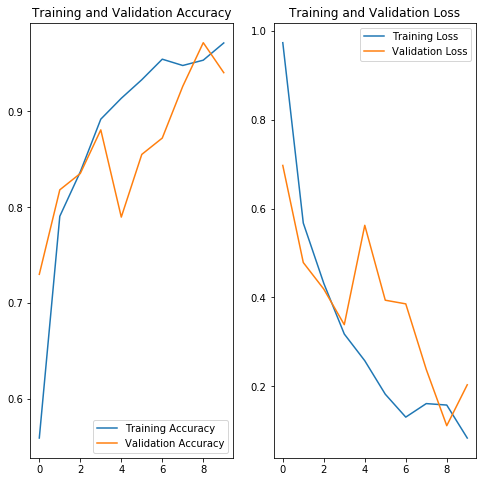

In [163]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoches), acc, label='Training Accuracy')
plt.plot(range(epoches), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoches), loss, label='Training Loss')
plt.plot(range(epoches), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


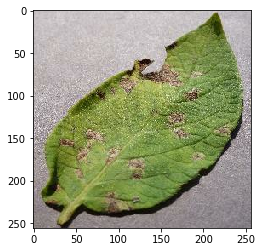

In [164]:
import numpy as np
for images_batch, labels_batch in test_df.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = cnn_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [165]:
def predict(cnn_model, img):
    img_a = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_a = tf.expand_dims(img_a, 0)

    predictions = cnn_model.predict(img_a)

    class_pred = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return class_pred, confidence

# Inference on few sample images



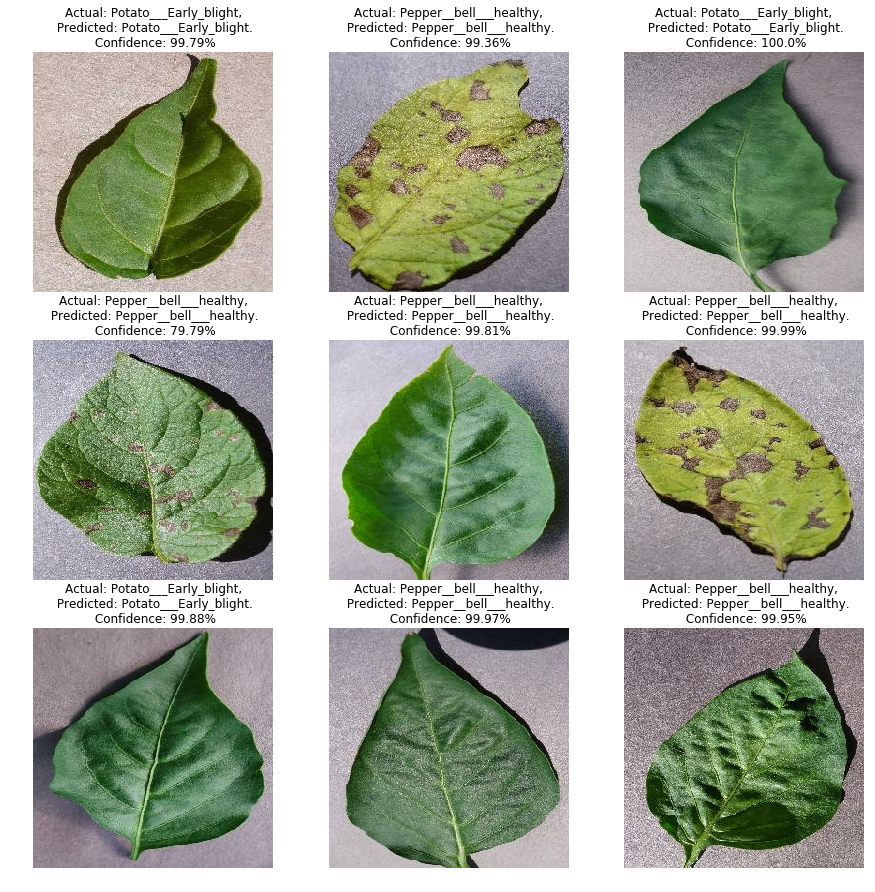

In [166]:
plt.figure(figsize=(15, 15))
for imag, l in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(imag[i].numpy().astype("uint8"))
        
        class_pred, confidence = predict(cnn_model, imag[i].numpy())
        actual_class = class_names[labels[i]] 
            
        plt.title(f"Actual: {actual_class},\n Predicted: {class_pred}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Conclusion:

• Model was built using Convolutional neural network and accuracy of 97% was found out after 10 epochs.
• After each epoch losses were reduced, and accuracy was increasing. 
• By increasing a greater number of epochs 100% accuracy can be obtained.
• Model was able to classify images correctly for different diseases.
